# Evaluation of model performance

Evaluation...

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer

from src.data.data_scaler import PreProcess
from src.data.data_loader import MIMICDataset,import_data
from src.utils import setup_logger
from src.training.training_nn import *
from src.models.models import ODERNN,GRU,LatentODE
from src.utils import seed_everything

In [2]:
from data.feature_sets import all_features

In [3]:
def glc_transform(x):
    x = x.copy()
    x[x > 0] = np.log(x[x > 0]) - np.log(140)
    return x

def glc_invtransform(x):
    x = x.copy()
    x = np.exp(x + np.log(140))
    return x

ginv = glc_invtransform

In [4]:
preproc = PreProcess(all_features(),QuantileTransformer())
df_train = pd.read_csv('data/train.csv')
preproc.fit(df_train)

## Model

In [5]:
model_path = 'experiments/mimic/LatentODE.pth'
cpt = torch.load(model_path)

In [6]:
print(len(all_features()))

85


In [7]:
model = LatentODE(85, 10, 0.1, 1,"cuda").to("cuda")

In [8]:
model.load_state_dict(cpt['state_dict'])

<All keys matched successfully>

In [9]:
model

LatentODE(
  (func): LODEFunc(
    (net): Sequential(
      (0): Linear(in_features=95, out_features=50, bias=True)
      (1): Tanh()
      (2): Linear(in_features=50, out_features=10, bias=True)
      (3): Tanh()
    )
  )
  (ls1): Linear(in_features=10, out_features=10, bias=True)
  (as1): Tanh()
  (ls2): Linear(in_features=10, out_features=1, bias=True)
  (os1): Softplus(beta=1, threshold=20)
  (lm1): Linear(in_features=10, out_features=10, bias=True)
  (am1): Tanh()
  (lm2): Linear(in_features=10, out_features=1, bias=True)
)

## Test data

In [10]:
df_test = import_data("data/test.csv")
print(df_test.shape)

(78557, 97)


In [11]:
df_test = preproc.transform(df_test)

In [12]:
df_test['dt'] = df_test.timer_dt - df_test.timer

(array([55924.,     0.,     0.,     0.,     0.,     0.,   238.,  7284.,
         8097.,  7014.]),
 array([0.        , 0.09999823, 0.19999647, 0.2999947 , 0.39999293,
        0.49999117, 0.5999894 , 0.69998764, 0.79998587, 0.8999841 ,
        0.99998234]),
 <BarContainer object of 10 artists>)

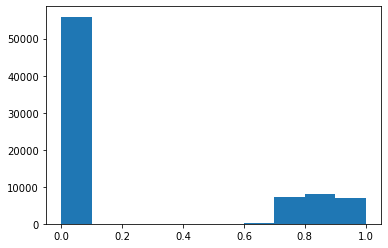

In [13]:
plt.hist(df_test.input_hrs)

# Predict

In [14]:
dl_test = DataLoader(MIMICDataset(df_test,all_features()),batch_size=1)
dataloaders = {'test':dl_test}
loss_test,error_tests,y_preds,y_tests,msks = model.evaluate(dataloaders["test"])

reconfiguring data...


100%|██████████| 4123/4123 [13:37<00:00,  5.05it/s]  

eval_rmse : 40.107
eval_loss : -0.005


In [16]:
mu = [y[0] for y in y_preds]
sig = [y[1] for y in y_preds]
msks = np.concatenate([m.squeeze(0) for m in msks])
df_test.head()

,subject_id,hadm_id,icustay_id,icu_admissiontime,icu_dischargetime,timer,timer_dt,glc,glc_dt,msk,...,demo_gender_F,demo_gender_M,demo_ethnicity_grouped_asian,demo_ethnicity_grouped_black,demo_ethnicity_grouped_hispanic,demo_ethnicity_grouped_native,demo_ethnicity_grouped_other,demo_ethnicity_grouped_unknown,demo_ethnicity_grouped_white,dt
0,41710,181955,200028,0.0,69.68,1.05,5.02,0.346625,0.611317,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.97
1,41710,181955,200028,0.0,69.68,5.02,13.28,0.611317,NaN,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.26
2,41710,181955,200028,0.0,69.68,13.28,19.40,0.611317,0.966441,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.12
3,41710,181955,200028,0.0,69.68,19.40,23.83,0.966441,0.872488,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.43
4,41710,181955,200028,0.0,69.68,23.83,29.12,0.872488,NaN,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.29


## Evaluate

text

In [17]:
df_test['mu'] = np.concatenate(mu)
df_test['sig'] = np.concatenate(sig)
df_test['lower80'] = df_test['mu'] - 1.281552*df_test['sig']
df_test['upper80'] = df_test['mu'] + 1.281552*df_test['sig']
df_test['lower95'] = df_test['mu'] - 1.959964*df_test['sig']
df_test['upper95'] = df_test['mu'] + 1.959964*df_test['sig']
df_test['lower99'] = df_test['mu'] - 3.290527*df_test['sig']
df_test['upper99'] = df_test['mu'] + 3.290527*df_test['sig']

In [18]:
res80 = sum((df_test['lower80'] < df_test.glc_dt) & (df_test['upper80'] > df_test.glc_dt) & (df_test.msk == 0)) / sum(df_test.msk == 0)
res95 = sum((df_test['lower95'] < df_test.glc_dt) & (df_test['upper95'] > df_test.glc_dt) & (df_test.msk == 0)) / sum(df_test.msk == 0)
res99 = sum((df_test['lower99'] < df_test.glc_dt) & (df_test['upper99'] > df_test.glc_dt) & (df_test.msk == 0)) / sum(df_test.msk == 0)
print("coverage of 80% prediction interval: {:05.4f}".format(res80))
print("coverage of 95% prediction interval: {:05.4f}".format(res95))
print("coverage of 99% prediction interval: {:05.4f}".format(res99))

coverage of 80% prediction interval: 0.8347
coverage of 95% prediction interval: 0.9480
coverage of 99% prediction interval: 0.9936


In [19]:
dts = np.linspace(0,11,12)
dts = np.append(dts,12.)
for i in range(dts.shape[0]-1):
    print('time ahead (hours): {:05.2f}-{:05.2f}'.format(dts[i],dts[i+1]))
    msk = (df_test.msk==0) & (df_test.dt >= dts[i]) & (df_test.dt < dts[i+1])
    res80 = sum((df_test['lower80'] < df_test.glc_dt) & (df_test['upper80'] > df_test.glc_dt) & msk) / sum(msk)
    res95 = sum((df_test['lower95'] < df_test.glc_dt) & (df_test['upper95'] > df_test.glc_dt) & msk) / sum(msk)
    res99 = sum((df_test['lower99'] < df_test.glc_dt) & (df_test['upper99'] > df_test.glc_dt) & msk) / sum(msk)
    print("coverage of 80% prediction interval: {:05.4f}".format(res80))
    print("coverage of 95% prediction interval: {:05.4f}".format(res95))
    print("coverage of 99% prediction interval: {:05.4f}".format(res99))

time ahead (hours): 00.00-01.00
coverage of 80% prediction interval: 0.8663
coverage of 95% prediction interval: 0.9653
coverage of 99% prediction interval: 0.9955
time ahead (hours): 01.00-02.00
coverage of 80% prediction interval: 0.8622
coverage of 95% prediction interval: 0.9632
coverage of 99% prediction interval: 0.9956
time ahead (hours): 02.00-03.00
coverage of 80% prediction interval: 0.8320
coverage of 95% prediction interval: 0.9432
coverage of 99% prediction interval: 0.9938
time ahead (hours): 03.00-04.00
coverage of 80% prediction interval: 0.7933
coverage of 95% prediction interval: 0.9273
coverage of 99% prediction interval: 0.9885
time ahead (hours): 04.00-05.00
coverage of 80% prediction interval: 0.8021
coverage of 95% prediction interval: 0.9333
coverage of 99% prediction interval: 0.9930
time ahead (hours): 05.00-06.00
coverage of 80% prediction interval: 0.8260
coverage of 95% prediction interval: 0.9408
coverage of 99% prediction interval: 0.9929
time ahead (hour

In [20]:
print("interval coverage when hypoglycaemia region...")
dts = np.linspace(0,11,12)
dts = np.append(dts,12.)
for i in range(dts.shape[0]-1):
    print('time ahead (hours): {:05.2f}-{:05.2f}'.format(dts[i],dts[i+1]))
    msk = (df_test.msk==0) & (df_test.dt >= dts[i]) & (df_test.dt < dts[i+1]) & (ginv(df_test.glc_dt) < 70)
    res80 = sum((df_test['lower80'] < df_test.glc_dt) & (df_test['upper80'] > df_test.glc_dt) & msk) / sum(msk)
    res95 = sum((df_test['lower95'] < df_test.glc_dt) & (df_test['upper95'] > df_test.glc_dt) & msk) / sum(msk)
    res99 = sum((df_test['lower99'] < df_test.glc_dt) & (df_test['upper99'] > df_test.glc_dt) & msk) / sum(msk)
    print("coverage of 80% prediction interval: {:05.4f}".format(res80))
    print("coverage of 95% prediction interval: {:05.4f}".format(res95))
    print("coverage of 99% prediction interval: {:05.4f}".format(res99))

interval coverage when hypoglycaemia region...
time ahead (hours): 00.00-01.00
coverage of 80% prediction interval: 0.3309
coverage of 95% prediction interval: 0.6801
coverage of 99% prediction interval: 0.9118
time ahead (hours): 01.00-02.00
coverage of 80% prediction interval: 0.2396
coverage of 95% prediction interval: 0.5486
coverage of 99% prediction interval: 0.8785
time ahead (hours): 02.00-03.00
coverage of 80% prediction interval: 0.2793
coverage of 95% prediction interval: 0.5315
coverage of 99% prediction interval: 0.8378
time ahead (hours): 03.00-04.00
coverage of 80% prediction interval: 0.2600
coverage of 95% prediction interval: 0.4700
coverage of 99% prediction interval: 0.7500
time ahead (hours): 04.00-05.00
coverage of 80% prediction interval: 0.0941
coverage of 95% prediction interval: 0.3647
coverage of 99% prediction interval: 0.7529
time ahead (hours): 05.00-06.00
coverage of 80% prediction interval: 0.1182
coverage of 95% prediction interval: 0.3455
coverage of 9

In [21]:
dts = np.linspace(0,6,10)
for dt in dts:
    print("interval coverage when hypoglycaemia region...")
    print('time ahead (hours): {:05.2f}'.format(dt))
    _msk_ = (df_test.msk == 0) & (ginv(df_test.glc_dt) < 70) & (df_test.timer_dt - df_test.timer > dt)
    res80 = sum((df_test['lower80'] < df_test.glc_dt) & (df_test['upper80'] > df_test.glc_dt) & _msk_) / sum(_msk_)
    res95 = sum((df_test['lower95'] < df_test.glc_dt) & (df_test['upper95'] > df_test.glc_dt) & _msk_) / sum(_msk_)
    res99 = sum((df_test['lower99'] < df_test.glc_dt) & (df_test['upper99'] > df_test.glc_dt) & _msk_) / sum(_msk_)
    print("coverage of 80% prediction interval: {:05.4f}".format(res80))
    print("coverage of 95% prediction interval: {:05.4f}".format(res95))
    print("coverage of 99% prediction interval: {:05.4f}".format(res99))

interval coverage when hypoglycaemia region...
time ahead (hours): 00.00
coverage of 80% prediction interval: 0.2304
coverage of 95% prediction interval: 0.5068
coverage of 99% prediction interval: 0.8197
interval coverage when hypoglycaemia region...
time ahead (hours): 00.67
coverage of 80% prediction interval: 0.2149
coverage of 95% prediction interval: 0.4809
coverage of 99% prediction interval: 0.8037
interval coverage when hypoglycaemia region...
time ahead (hours): 01.33
coverage of 80% prediction interval: 0.1860
coverage of 95% prediction interval: 0.4149
coverage of 99% prediction interval: 0.7611
interval coverage when hypoglycaemia region...
time ahead (hours): 02.00
coverage of 80% prediction interval: 0.1740
coverage of 95% prediction interval: 0.3972
coverage of 99% prediction interval: 0.7381
interval coverage when hypoglycaemia region...
time ahead (hours): 02.67
coverage of 80% prediction interval: 0.1679
coverage of 95% prediction interval: 0.3912
coverage of 99% pre

In [22]:
df_test["glc_dt_locf"] = df_test.glc
df_test.loc[df_test.glc_dt_locf == 0,'glc_dt_locf'] = np.NaN
df_test["glc_dt_locf"] = df_test.groupby('icustay_id')["glc_dt_locf"].ffill()
res_rmse_locf = math.sqrt(np.mean((ginv(df_test.glc_dt_locf[df_test.msk==0]) - ginv(df_test.glc_dt[df_test.msk==0]))**2))
print("RMSE (locf): {:05.4f}".format(res_rmse_locf))

RMSE (locf): 44.0801


In [23]:
res_rmse_model = math.sqrt(np.mean((ginv(df_test.mu[df_test.msk==0]) - ginv(df_test.glc_dt[df_test.msk==0]))**2))
print("RMSE (model): {:05.4f}".format(res_rmse_model))

RMSE (model): 40.6188


In [24]:
print("RMSE...")
dts = np.linspace(0,11,12)
dts = np.append(dts,12.)
dts[0] = 0.5
for i in range(dts.shape[0]-1):
    print('time ahead (hours): {:05.2f}-{:05.2f}'.format(dts[i],dts[i+1]))
    msk = (df_test.msk==0) & (df_test.dt >= dts[i]) & (df_test.dt < dts[i+1])
    print("N: {:5}".format(sum(msk)))
    res_rmse_locf = math.sqrt(np.mean((ginv(df_test.glc_dt_locf[msk]) - ginv(df_test.glc_dt[msk]))**2))
    print("RMSE (locf): {:05.4f}".format(res_rmse_locf))
    res_rmse_model = math.sqrt(np.mean((ginv(df_test.mu[msk]) - ginv(df_test.glc_dt[msk]))**2))
    print("RMSE (model): {:05.4f}".format(res_rmse_model))
    print("{:05.4f}".format(res_rmse_model/res_rmse_locf))

RMSE...
time ahead (hours): 00.50-01.00
N:  8372
RMSE (locf): 33.2910
RMSE (model): 33.1894
0.9969
time ahead (hours): 01.00-02.00
N: 15469
RMSE (locf): 36.0315
RMSE (model): 34.3808
0.9542
time ahead (hours): 02.00-03.00
N:  5144
RMSE (locf): 45.3529
RMSE (model): 42.4962
0.9370
time ahead (hours): 03.00-04.00
N:  3643
RMSE (locf): 55.6535
RMSE (model): 50.9200
0.9149
time ahead (hours): 04.00-05.00
N:  4840
RMSE (locf): 56.0239
RMSE (model): 49.8989
0.8907
time ahead (hours): 05.00-06.00
N:  9056
RMSE (locf): 49.6703
RMSE (model): 43.8876
0.8836
time ahead (hours): 06.00-07.00
N: 11477
RMSE (locf): 43.9566
RMSE (model): 40.5479
0.9225
time ahead (hours): 07.00-08.00
N:  2022
RMSE (locf): 48.0570
RMSE (model): 45.3022
0.9427
time ahead (hours): 08.00-09.00
N:   836
RMSE (locf): 56.7502
RMSE (model): 48.0657
0.8470
time ahead (hours): 09.00-10.00
N:   667
RMSE (locf): 54.7058
RMSE (model): 46.7840
0.8552
time ahead (hours): 10.00-11.00
N:   785
RMSE (locf): 58.4267
RMSE (model): 50.700

In [25]:
# dts = np.linspace(0,6,10)
# for dt in dts:
#     print('time ahead (hours): {:05.2f}'.format(dt))
#     msk = (df_test.msk==0) & (df_test.timer_dt - df_test.timer > dt)
#     res_rmse_locf = math.sqrt(np.mean((ginv(df_test.glc_dt_locf[msk]) - ginv(df_test.glc_dt[msk]))**2))
#     print("RMSE (locf): {:05.4f}".format(res_rmse_locf))
#     res_rmse_model = math.sqrt(np.mean((ginv(df_test.mu[msk]) - ginv(df_test.glc_dt[msk]))**2))
#     print("RMSE (model): {:05.4f}".format(res_rmse_model))
#     print("{:05.4f}".format(res_rmse_model/res_rmse_locf))

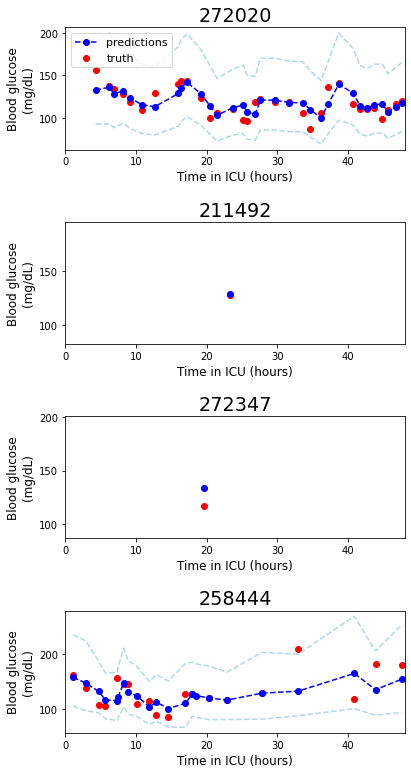

In [26]:
import random
fig, axs = plt.subplots(4,1,figsize=(6,12))
plt.rcParams['font.size'] = '16'

ids = random.sample(list(df_test.icustay_id.unique()),4)
for i in range(4):
    msk_i = (df_test['icustay_id'] == ids[i]) & (df_test['timer_dt'] < 48)
    xs = df_test[msk_i].timer_dt
    axs[i].plot(xs,glc_invtransform(df_test.mu[msk_i]),label='predictions',linestyle='--', marker='o', color='b')
    axs[i].plot(xs, glc_invtransform(df_test.lower95[msk_i]),label='',linestyle='--', color='lightblue')
    axs[i].plot(xs,glc_invtransform(df_test.upper95[msk_i]),label='',linestyle='--', color='lightblue')
#     axs[i].fill_between(xs,glc_invtransform(df_test.mu[msk_i])-glc_invtransform(df_test.lower95[msk_i]),
#                         glc_invtransform(df_test.mu[msk_i])+glc_invtransform(df_test.lower95[msk_i]),
#                         label='', color='lightblue',interpolate=True)
    axs[i].scatter(xs,glc_invtransform(df_test.glc_dt[msk_i]),label='truth', marker='o', color='red')
    axs[i].set_xlabel('Time in ICU (hours)', fontsize=12)
    axs[i].set_ylabel('Blood glucose\n(mg/dL)', fontsize=12)
    axs[i].set_xlim(0,48)
    axs[i].set_title(ids[i])
    if i == 0:
        axs[i].legend(fontsize = 'x-small')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [27]:
mu = [y[0] for y in y_preds]
sig = [y[1] for y in y_preds]
mu = np.concatenate(mu)
sig = np.concatenate(sig)
y_tests = np.concatenate(y_tests)

In [28]:
prob_test = scipy.stats.norm(mu, sig).cdf(y_tests)

In [29]:
# a forecast is overdispersed if var < 0.8333 and underdispersed if var > 0.8333
print(1/12)
varF = np.var(prob_test[~msks])
print('variance of probs: {:05.4f}'.format(varF))
if varF > 1/12:
    print("underdispersed")
else: 
    print("overdispersed")

0.08333333333333333
variance of probs: 0.0726
overdispersed


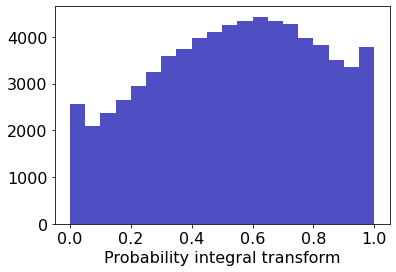

In [30]:
plt.hist(prob_test[~msks], color=['#0504aa'],alpha=0.7, bins=20)
plt.xlabel("Probability integral transform")
plt.show()

In [33]:
prob_test[~msks]

array([[0.80572914],
       [0.95002073],
       [0.71379929],
       ...,
       [0.93888149],
       [0.16785077],
       [0.04997783]])

In [35]:
df_test['probs'] = prob_test

In [40]:
df_test.to_csv('data/eval/test.csv',index=False)

In [41]:
prob_test[~msks]

array([[0.80572914],
       [0.95002073],
       [0.71379929],
       ...,
       [0.93888149],
       [0.16785077],
       [0.04997783]])

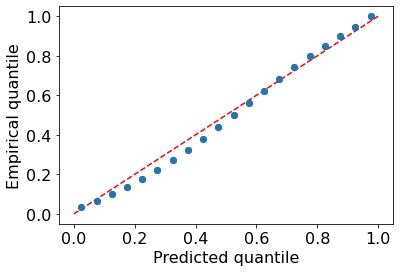

In [31]:
# quantile plot
def calibration_plot(prob_test):
    nbins = 20
    x1s = plt.hist(prob_test,bins=nbins)
    plt.close()
    xbin = np.zeros(nbins)
    for i in range(nbins):
        xbin[i] = (x1s[1][i] + x1s[1][i+1])/2
    qs = np.cumsum(x1s[0])/sum(x1s[0])
    errors = np.sqrt(qs*(1-qs)/sum(x1s[0]))
    plt.scatter(xbin,qs)
    plt.errorbar(xbin, qs, yerr=2*errors, fmt='o')
    plt.plot(np.linspace(0,1),np.linspace(0,1),'--r')
    plt.xlabel("Predicted quantile")
    plt.ylabel("Empirical quantile")
    plt.show()
calibration_plot(prob_test[~msks])

In [429]:
x,y,msk,t = next(iter(dataloaders["test"]))

In [430]:
ginv(x[:,:,0].numpy())

array([[198.00002, 257.99997, 257.99997, 368.     , 334.9999 , 334.9999 ,
        288.     , 288.     , 288.     , 288.     , 288.     , 288.     ]],
      dtype=float32)

In [431]:
t[0]

tensor([[ 1.0500,  5.0200],
        [ 5.0200, 13.2800],
        [13.2800, 19.4000],
        [19.4000, 23.8300],
        [23.8300, 29.1200],
        [29.1200, 36.7700],
        [36.7700, 38.7700],
        [38.7700, 42.7700],
        [42.7700, 48.3000],
        [48.3000, 48.7700],
        [48.7700, 52.7700],
        [52.7700, 63.2800]])

In [432]:
x[0][0]

tensor([0.3466, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4890, 0.5135, 0.0000,
        1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.2868, 0.3829, 0.1071, 0.1577, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9748, 0.9793,
        0.9729, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3408, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 1.0000])

In [433]:
x[0][0][5] = 0.0

In [434]:
ginv(model(t.to("cuda"),x.to("cuda"))[0].detach().cpu().numpy())

array([[191.68753],
       [213.30302],
       [227.82916],
       [267.07733],
       [247.55693],
       [250.65355],
       [238.89648],
       [239.30066],
       [230.94965],
       [233.10822],
       [233.9514 ],
       [227.77658]], dtype=float32)

In [435]:
all_features()[0:11]

['glc',
 'input_short_injection',
 'input_short_push',
 'input_intermediate',
 'input_long',
 'input_hrs',
 'demo_admission_age',
 'demo_weight_first',
 'demo_height_first',
 'demo_diabetes_uncomplicated',
 'demo_diabetes_complicated']

In [436]:
x = x[:,0:2,:]
t = t[:,0:2,:]

In [449]:
ntimes = 100
ninsulin = 10
x[:,1,1] = 0.0
x[:,1,4] = 0.0
x[:,1,2] = 0.0
x[:,1,3] = 0.0
res = np.zeros((10,ntimes))
insulin = np.concatenate((np.zeros((1,1)),np.linspace(0.7,1.0,ninsulin-1).reshape(-1,1)))
times = np.linspace(0.5,6,100)
for i in range(ninsulin):
    x[:,1,1] = insulin[i,:].item()
    for j in range(ntimes):
        t[:,1,1] = t[:,1,0] + times[j]
        mu,sig = model(t.to("cuda"),x.to("cuda"))
        res[i,j] = mu[1].detach().cpu().item()

In [450]:
insulin 

array([[0.    ],
       [0.7   ],
       [0.7375],
       [0.775 ],
       [0.8125],
       [0.85  ],
       [0.8875],
       [0.925 ],
       [0.9625],
       [1.    ]])

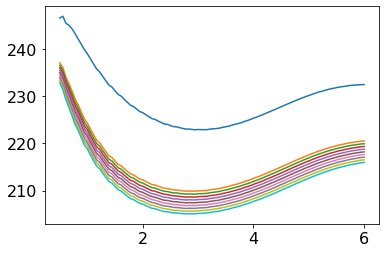

In [451]:
for p in range(ninsulin):
    plt.plot(times,ginv(res[p]))
plt.show()

In [452]:
res

array([[0.56566513, 0.56718773, 0.56111789, 0.55941504, 0.55627924,
        0.55211711, 0.5473935 , 0.54293537, 0.53818464, 0.53445035,
        0.52992159, 0.5253877 , 0.52090502, 0.51821697, 0.5141626 ,
        0.51023042, 0.50643468, 0.50450444, 0.50111336, 0.49786431,
        0.49623787, 0.49333066, 0.49055767, 0.48791775, 0.48668438,
        0.48432699, 0.48209292, 0.48104125, 0.47905749, 0.4771899 ,
        0.47543722, 0.47468901, 0.47316304, 0.4717465 , 0.47043842,
        0.46999061, 0.468894  , 0.46790087, 0.46765706, 0.46686652,
        0.46617496, 0.46558097, 0.46564543, 0.46524158, 0.4649303 ,
        0.46520206, 0.46507037, 0.4650259 , 0.46506691, 0.46561983,
        0.4658241 , 0.46610764, 0.46646887, 0.46727011, 0.46777499,
        0.4683505 , 0.46929997, 0.47000253, 0.47076797, 0.47159386,
        0.47271502, 0.47364289, 0.47462195, 0.47582704, 0.47688624,
        0.47798622, 0.47912338, 0.48039675, 0.48158062, 0.48278913,
        0.48401785, 0.48528713, 0.48652428, 0.48

In [308]:
inject_times = df_test.loc[df_test.input_short_injection > 0,["timer","timer_dt"]]

(0.0, 24.0)

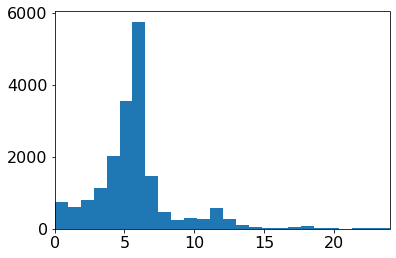

In [315]:
plt.hist(inject_times.timer_dt - inject_times.timer,bins=100)
plt.xlim(0,24)

## Predict with dropout

In [ ]:
B = 10
res_mu = np.zeros((B,df_test.shape[0]))
res_sig = np.zeros((B,df_test.shape[0]))
with tqdm(total=B) as t:
    for b in range(B):
        loss,rmse, y_preds_b, ll,jj = model.evaluate(dataloaders["test"],p=0.1,verbose=False)
        mu_b = np.concatenate([y[0] for y in y_preds_b])
        sig_b = np.concatenate([y[1] for y in y_preds_b])
        res_mu[b,:] = mu_b.squeeze(1)
        res_sig[b,:] = sig_b.squeeze(1)
        t.update()

In [ ]:
res_mu_mean = np.mean(res_mu,axis=0)
res_sig_mean = np.median(res_sig,axis=0)

In [ ]:
dts = np.linspace(0,6,10)
for dt in dts:
    print('time ahead (hours): {:05.2f}'.format(dt))
    msk = (df_test.msk==0) & (df_test.timer_dt - df_test.timer > dt)
    res_rmse_locf = math.sqrt(np.mean((ginv(df_test.glc_dt_locf[msk]) - ginv(df_test.glc_dt[msk]))**2))
    print("RMSE (locf): {:05.4f}".format(res_rmse_locf))
    res_rmse_model = math.sqrt(np.mean((ginv(res_mu_mean[msk]) - ginv(df_test.glc_dt[msk]))**2))
    print("RMSE (model): {:05.4f}".format(res_rmse_model))
    print("{:05.4f}".format(res_rmse_model/res_rmse_locf))

In [ ]:
prob_test_B = scipy.stats.norm(np.expand_dims(res_mu_mean,1), np.expand_dims(res_sig_mean,1)).cdf(y_tests)

In [ ]:
# a forecast is overdispersed if var < 0.8333 and underdispersed if var > 0.8333
print(1/12)
varF = np.var(prob_test_B[~msks])
print('variance of probs: {:05.4f}'.format(varF))
if varF > 1/12:
    print("underdispersed")
else: 
    print("overdispersed")

In [ ]:
plt.hist(prob_test_B[~msks], color=['#0504aa'],alpha=0.7, bins=20)
plt.xlabel("Probability integral transform")
plt.show()

In [ ]:
# quantile plot
def calibration_plot(prob_test):
    nbins = 20
    x1s = plt.hist(prob_test,bins=nbins)
    plt.close()
    xbin = np.zeros(nbins)
    for i in range(nbins):
        xbin[i] = (x1s[1][i] + x1s[1][i+1])/2
    qs = np.cumsum(x1s[0])/sum(x1s[0])
    errors = np.sqrt(qs*(1-qs)/sum(x1s[0]))
    plt.scatter(xbin,qs)
    plt.errorbar(xbin, qs, yerr=2*errors, fmt='o')
    plt.plot(np.linspace(0,1),np.linspace(0,1),'--r')
    plt.xlabel("Predicted quantile")
    plt.ylabel("Empirical quantile")
    plt.show()
calibration_plot(prob_test_B[~msks])

In [ ]:
df_test['muB'] = (res_mu_mean)
df_test['sigB'] = (res_sig_mean)
df_test['lower80B'] = df_test['muB'] - 1.281552*df_test['sigB']
df_test['upper80B'] = df_test['muB'] + 1.281552*df_test['sigB']
df_test['lower95B'] = df_test['muB'] - 1.959964*df_test['sigB']
df_test['upper95B'] = df_test['muB'] + 1.959964*df_test['sigB']
df_test['lower99B'] = df_test['muB'] - 3.290527*df_test['sigB']
df_test['upper99B'] = df_test['muB'] + 3.290527*df_test['sigB']

In [ ]:
res80 = sum((df_test['lower80B'] < df_test.glc_dt) & (df_test['upper80B'] > df_test.glc_dt) & (df_test.msk == 0)) / sum(df_test.msk == 0)
res95 = sum((df_test['lower95B'] < df_test.glc_dt) & (df_test['upper95B'] > df_test.glc_dt) & (df_test.msk == 0)) / sum(df_test.msk == 0)
res99 = sum((df_test['lower99B'] < df_test.glc_dt) & (df_test['upper99B'] > df_test.glc_dt) & (df_test.msk == 0)) / sum(df_test.msk == 0)
print("coverage of 80% prediction interval: {:05.4f}".format(res80))
print("coverage of 95% prediction interval: {:05.4f}".format(res95))
print("coverage of 99% prediction interval: {:05.4f}".format(res99))

In [ ]:
print("interval coverage when hypoglycaemia region...")
_msk_ = (df_test.msk == 0) & (ginv(df_test.glc_dt) < 70)
res80 = sum((df_test['lower80B'] < df_test.glc_dt) & (df_test['upper80B'] > df_test.glc_dt) & _msk_) / sum(_msk_)
res95 = sum((df_test['lower95B'] < df_test.glc_dt) & (df_test['upper95B'] > df_test.glc_dt) & _msk_) / sum(_msk_)
res99 = sum((df_test['lower99B'] < df_test.glc_dt) & (df_test['upper99B'] > df_test.glc_dt) & _msk_) / sum(_msk_)
print("coverage of 80% prediction interval: {:05.4f}".format(res80))
print("coverage of 95% prediction interval: {:05.4f}".format(res95))
print("coverage of 99% prediction interval: {:05.4f}".format(res99))

In [ ]:
dts = np.linspace(0,6,10)
for dt in dts:
    print("interval coverage when hypoglycaemia region...")
    print('time ahead (hours): {:05.2f}'.format(dt))
    _msk_ = (df_test.msk == 0) & (ginv(df_test.glc_dt) < 70) & (df_test.dt > dt)
    res80 = sum((df_test['lower80B'] < df_test.glc_dt) & (df_test['upper80B'] > df_test.glc_dt) & _msk_) / sum(_msk_)
    res95 = sum((df_test['lower95B'] < df_test.glc_dt) & (df_test['upper95B'] > df_test.glc_dt) & _msk_) / sum(_msk_)
    res99 = sum((df_test['lower99B'] < df_test.glc_dt) & (df_test['upper99B'] > df_test.glc_dt) & _msk_) / sum(_msk_)
    print("coverage of 80% prediction interval: {:05.4f}".format(res80))
    print("coverage of 95% prediction interval: {:05.4f}".format(res95))
    print("coverage of 99% prediction interval: {:05.4f}".format(res99))

In [ ]:
model(torch.randn(1,1,4),torch.rand(1,1))

In [ ]:
# injection 	input_hrs 	input 	glc
x_ = torch.tensor([0.,0.,0.,glc_transform(np.array(200.0))]).unsqueeze(0).unsqueeze(0).float()
dt_ = torch.tensor([1.0]).unsqueeze(0).float()
ys_ = model(x_,dt_)
ginv(ys_[0].detach().cpu().numpy())

In [ ]:
x_ = torch.tensor([0.,12.,0.,glc_transform(np.array(200.0))]).unsqueeze(0).unsqueeze(0).float()
dt_ = torch.tensor([1.0]).unsqueeze(0).float()
ys_ = model(x_,dt_)
ginv(ys_[0].detach().cpu().numpy())

In [ ]:
x_ = torch.tensor([1.,0.,20.,glc_transform(np.array(200.0))]).unsqueeze(0).unsqueeze(0).float()
dt_ = torch.tensor([1.0]).unsqueeze(0).float()
ys_ = model(x_,dt_)
ginv(ys_[0].detach().cpu().numpy())

In [ ]:
x_ = torch.tensor(np.array(([1.,0.,4.,0.],[1.,0.,4.,0.]))).unsqueeze(0).float()
dt_ = torch.tensor(np.array(([2.0],[2.0]))).unsqueeze(0).unsqueeze(0).float()
ys_ = model(x_,dt_)
ginv(ys_[0].detach().numpy())

In [ ]:
FEATURE_VARS = ["injection","input_hrs","input","glc"]

In [ ]:
torch.tensor(np.array(([1.,0.,4.,0.],[1.,0.,4.,0.]))).shape

In [ ]:
x_ = torch.tensor(np.array(([0.,0.,0.,glc_transform(np.array(150.0))],[0.,10.,0.,0.]))).float()
dt_ = torch.tensor(np.array(([2354.],[0.4]))).float()
ys_ = model(x_,dt_)


In [ ]:
ginv(ys_[0].detach().numpy())